# Project: Dog vs Cat Classification

In [338]:
from pathlib import Path
import os
import torch
from torch import nn

In [339]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [340]:
data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"

train_path, test_path

(WindowsPath('data/train'), WindowsPath('data/test'))

In [341]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Cat, Shape: (500, 379, 3)')

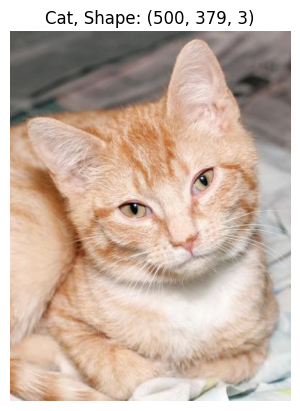

In [342]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
image_path_list = list(data_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img_is_array = np.asarray(img)

plt.imshow(img)
plt.axis(False)
plt.title(f"{image_class}, Shape: {img_is_array.shape}")

In [343]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [344]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [345]:
transformed_image = data_transform(img)
transformed_image

tensor([[[0.3373, 0.3373, 0.3373,  ..., 0.6157, 0.5843, 0.5686],
         [0.3451, 0.3569, 0.3647,  ..., 0.5804, 0.5725, 0.5725],
         [0.3529, 0.3725, 0.3843,  ..., 0.5529, 0.5569, 0.5608],
         ...,
         [0.7490, 0.8235, 0.8745,  ..., 0.8353, 0.8353, 0.8392],
         [0.6902, 0.7216, 0.7922,  ..., 0.8627, 0.8627, 0.8627],
         [0.8784, 0.7961, 0.7176,  ..., 0.8980, 0.9020, 0.9059]],

        [[0.3451, 0.3451, 0.3412,  ..., 0.5608, 0.5294, 0.5137],
         [0.3529, 0.3647, 0.3686,  ..., 0.5294, 0.5176, 0.5176],
         [0.3529, 0.3725, 0.3843,  ..., 0.5020, 0.5098, 0.5137],
         ...,
         [0.5255, 0.6471, 0.7529,  ..., 0.8549, 0.8588, 0.8627],
         [0.5176, 0.5451, 0.6471,  ..., 0.8824, 0.8863, 0.8863],
         [0.8118, 0.7098, 0.6275,  ..., 0.9059, 0.9137, 0.9137]],

        [[0.3333, 0.3333, 0.3294,  ..., 0.5608, 0.5294, 0.5098],
         [0.3373, 0.3490, 0.3569,  ..., 0.5255, 0.5176, 0.5137],
         [0.3373, 0.3569, 0.3686,  ..., 0.5020, 0.5098, 0.

Text(0.5, 1.0, 'Cat, Shape: torch.Size([3, 64, 64])')

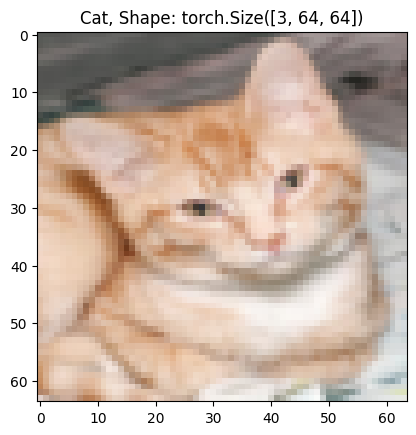

In [346]:
plt.imshow(transformed_image.permute(1, 2, 0))
plt.title(f"{image_class}, Shape: {transformed_image.shape}")

# Loading data using 'ImageFolder'

In [347]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=test_data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 1648
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 353
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [348]:
# Get class names as list
class_names = train_data.classes
class_names

['Cat', 'Dog']

In [349]:
# Get class names as dictionary 
class_dict = train_data.class_to_idx
class_dict

{'Cat': 0, 'Dog': 1}

In [350]:
len(train_data), len(test_data)

(1648, 353)

# Turn loaded images into 'DataLoader'

In [351]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x206b41baaf0>,
 <torch.utils.data.dataloader.DataLoader at 0x206b41a1c40>)

In [352]:
img_custom, label_custom = next(iter(train_dataloader))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [357]:
class DogVsCat(nn.Module):
    def __init__(self, input_shape, hidden_layers, output_shape):
        super().__init__()

        self.conv_block_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers * 2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layers*2,
                      out_channels=hidden_layers*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers*2*2,
                      out_channels=hidden_layers*2*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2*2),
            nn.ReLU(),
           # nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layers*16*16*8,
                      #out_features=output_shape
                      out_features=128),
            nn.ReLU(),
            nn.Linear(128, output_shape)
        )

    def forward(self, x):
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_1(x)
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_2(x)
        #print(f"Shape: {x.shape}")
        x = self.classification(x)
        #print(f"Shape: {x.shape}")
        return x
        

In [358]:
model_0 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_0

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): S

In [359]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [360]:
# Check the correct shape on dummy tensor
dummy_input = torch.randn(32, 3, 64, 64)
output = model_0(dummy_input.to(device))
output

tensor([[-0.5478],
        [-0.5038],
        [-0.5961],
        [-0.5946],
        [-0.3204],
        [-0.5411],
        [-0.5803],
        [-0.5386],
        [-0.4319],
        [-0.4052],
        [-0.7881],
        [-0.5693],
        [-0.5638],
        [-0.4325],
        [-0.2411],
        [-0.6053],
        [-0.7199],
        [-0.4514],
        [-0.7263],
        [-0.6534],
        [-0.4698],
        [-0.6300],
        [-0.5571],
        [-0.7022],
        [-0.3901],
        [-0.4858],
        [-0.5566],
        [-0.7591],
        [-0.3862],
        [-0.2874],
        [-0.5645],
        [-0.6602]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [361]:
from tqdm import tqdm
import time

In [362]:
epochs = 5

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    model_0.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y = y.unsqueeze(dim=1).float()
        
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss /= len(train_dataloader)
    train_acc = (train_acc / len(train_dataloader)) * 100
    
    model_0.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model_0(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            test_acc += (test_pred_class==y).sum().item() / len(test_pred)
    
        test_loss /= len(test_dataloader)
        test_acc = (test_acc / len(test_dataloader)) * 100

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

 20%|██        | 1/5 [00:04<00:16,  4.25s/it]

Epoch: 0 | Train Loss: 1.0874, Train Accuracy: 57.93 | Test Loss: 0.6943622057636579, Test Accuracy: 61.979166666666664


 40%|████      | 2/5 [00:08<00:12,  4.29s/it]

Epoch: 1 | Train Loss: 0.6559, Train Accuracy: 65.69 | Test Loss: 0.5666967531045278, Test Accuracy: 72.39583333333334


 60%|██████    | 3/5 [00:13<00:08,  4.46s/it]

Epoch: 2 | Train Loss: 0.6185, Train Accuracy: 68.75 | Test Loss: 0.6063355952501297, Test Accuracy: 64.32291666666666


 80%|████████  | 4/5 [00:17<00:04,  4.39s/it]

Epoch: 3 | Train Loss: 0.6054, Train Accuracy: 68.93 | Test Loss: 0.6117191947996616, Test Accuracy: 66.92708333333334


100%|██████████| 5/5 [00:21<00:00,  4.36s/it]

Epoch: 4 | Train Loss: 0.5460, Train Accuracy: 72.00 | Test Loss: 0.5531149134039879, Test Accuracy: 73.69791666666666
Total time: 21.79200029373169


# Plot model_0 results

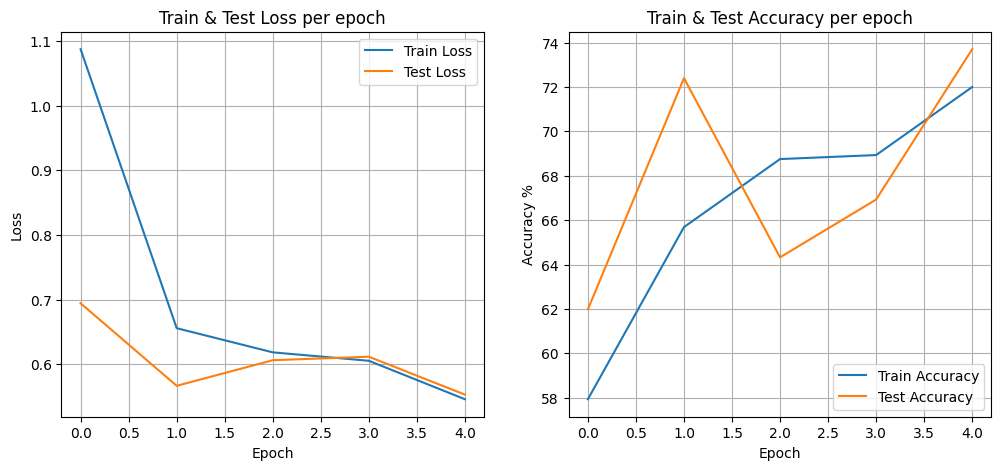

In [363]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()



In [364]:
print(len(results["train_loss"]), len(results["test_loss"]))
print(len(results["train_acc"]), len(results["test_acc"]))

5 5
5 5


In [365]:
# Build train and test function to make training easier
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device=device):

    train_loss, correct_preds, total_samples = 0, 0, 0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.unsqueeze(dim=1).float()
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        #train_acc += (y_pred_class==y).sum().item() / len(y_pred)
        correct_preds += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    train_loss /= len(dataloader)
    #train_acc = (train_acc / len(dataloader)) * 100
    train_acc = (correct_preds / total_samples) * 100
    
    return train_loss, train_acc

In [366]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    test_loss, correct_preds, total_samples = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            #test_acc += (test_pred_class==y).sum().item() / len(test_pred)
            correct_preds += (test_pred_class == y).sum().item()
            total_samples += y.size(0)
    
    test_loss /= len(dataloader)
    #test_acc = (test_acc / len(dataloader)) * 100
    test_acc = (correct_preds / total_samples) * 100
    return test_loss, test_acc

# Augmentation data

In [367]:
train_data_transform_augmentation = transforms.Compose([
    #transforms.Resize(size=(64, 64)),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #transforms.RandomAffine(degrees=15, translate=(1, 1)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # used to differentiate the data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_data = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_data_transform_augmentation, test_data

(Compose(
     RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ))

In [368]:
train_data_augmentation = datasets.ImageFolder(root=train_path,
                                               transform=train_data_transform_augmentation)
test_data_augmentation = datasets.ImageFolder(root=test_path,
                                              transform=test_data)

train_data_augmentation, test_data_augmentation

(Dataset ImageFolder
     Number of datapoints: 1648
     Root location: data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 353
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Norma

In [369]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_augmentation = DataLoader(dataset=train_data_augmentation,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)

test_dataloader_augmentation = DataLoader(dataset=test_data_augmentation,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)

train_dataloader_augmentation, test_dataloader_augmentation

(<torch.utils.data.dataloader.DataLoader at 0x206c976e8e0>,
 <torch.utils.data.dataloader.DataLoader at 0x206c976ee20>)

In [370]:
len(class_names)

2

In [371]:
model_1 = DogVsCat(input_shape=3, hidden_layers=8, output_shape=1).to(device)
model_1

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequen

In [372]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.00025)
#optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01, momentum=0.9)
loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.00025
     maximize: False
     weight_decay: 0
 ))

In [373]:
# Train model_1 on augmentation data
epochs = 50

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model_1,
               dataloader=train_dataloader_augmentation,
               loss_fn=loss_fn,
               optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_1,
              dataloader=test_dataloader_augmentation,
              loss_fn=loss_fn)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  2%|▏         | 1/50 [00:06<05:05,  6.24s/it]

Epoch: 0 | Train Loss: 0.7181, Train Accuracy: 53.94 | Test Loss: 0.6625, Test Accuracy: 59.21


  4%|▍         | 2/50 [00:13<05:15,  6.58s/it]

Epoch: 1 | Train Loss: 0.6761, Train Accuracy: 58.25 | Test Loss: 0.6500, Test Accuracy: 64.87


  6%|▌         | 3/50 [00:19<05:14,  6.69s/it]

Epoch: 2 | Train Loss: 0.6644, Train Accuracy: 59.95 | Test Loss: 0.6251, Test Accuracy: 63.17


  8%|▊         | 4/50 [00:26<05:08,  6.70s/it]

Epoch: 3 | Train Loss: 0.6537, Train Accuracy: 61.83 | Test Loss: 0.6089, Test Accuracy: 66.57


 10%|█         | 5/50 [00:33<05:03,  6.75s/it]

Epoch: 4 | Train Loss: 0.6570, Train Accuracy: 59.89 | Test Loss: 0.6000, Test Accuracy: 63.17


 12%|█▏        | 6/50 [00:39<04:53,  6.67s/it]

Epoch: 5 | Train Loss: 0.6444, Train Accuracy: 62.38 | Test Loss: 0.5707, Test Accuracy: 71.95


 14%|█▍        | 7/50 [00:46<04:49,  6.74s/it]

Epoch: 6 | Train Loss: 0.6422, Train Accuracy: 62.44 | Test Loss: 0.6348, Test Accuracy: 59.21


 16%|█▌        | 8/50 [00:53<04:38,  6.64s/it]

Epoch: 7 | Train Loss: 0.6339, Train Accuracy: 64.32 | Test Loss: 0.5888, Test Accuracy: 66.57


 18%|█▊        | 9/50 [00:59<04:28,  6.54s/it]

Epoch: 8 | Train Loss: 0.6311, Train Accuracy: 62.62 | Test Loss: 0.5680, Test Accuracy: 65.44


 20%|██        | 10/50 [01:06<04:21,  6.55s/it]

Epoch: 9 | Train Loss: 0.6206, Train Accuracy: 65.84 | Test Loss: 0.5775, Test Accuracy: 69.12


 22%|██▏       | 11/50 [01:12<04:14,  6.53s/it]

Epoch: 10 | Train Loss: 0.6013, Train Accuracy: 66.32 | Test Loss: 0.5665, Test Accuracy: 71.67


 24%|██▍       | 12/50 [01:19<04:11,  6.63s/it]

Epoch: 11 | Train Loss: 0.6148, Train Accuracy: 65.53 | Test Loss: 0.5776, Test Accuracy: 64.02


 26%|██▌       | 13/50 [01:26<04:05,  6.65s/it]

Epoch: 12 | Train Loss: 0.6009, Train Accuracy: 66.81 | Test Loss: 0.5596, Test Accuracy: 68.84


 28%|██▊       | 14/50 [01:33<04:02,  6.75s/it]

Epoch: 13 | Train Loss: 0.6120, Train Accuracy: 67.35 | Test Loss: 0.5207, Test Accuracy: 72.52


 30%|███       | 15/50 [01:39<03:53,  6.67s/it]

Epoch: 14 | Train Loss: 0.6299, Train Accuracy: 63.11 | Test Loss: 0.5559, Test Accuracy: 65.16


 32%|███▏      | 16/50 [01:46<03:49,  6.74s/it]

Epoch: 15 | Train Loss: 0.5914, Train Accuracy: 67.90 | Test Loss: 0.5369, Test Accuracy: 71.10


 34%|███▍      | 17/50 [01:53<03:42,  6.74s/it]

Epoch: 16 | Train Loss: 0.6057, Train Accuracy: 66.38 | Test Loss: 0.5480, Test Accuracy: 69.12


 36%|███▌      | 18/50 [01:59<03:34,  6.71s/it]

Epoch: 17 | Train Loss: 0.5951, Train Accuracy: 69.11 | Test Loss: 0.5238, Test Accuracy: 75.64


 38%|███▊      | 19/50 [02:06<03:28,  6.72s/it]

Epoch: 18 | Train Loss: 0.5855, Train Accuracy: 69.24 | Test Loss: 0.5209, Test Accuracy: 75.35


 40%|████      | 20/50 [02:13<03:22,  6.75s/it]

Epoch: 19 | Train Loss: 0.5879, Train Accuracy: 68.57 | Test Loss: 0.5702, Test Accuracy: 64.59


 42%|████▏     | 21/50 [02:20<03:17,  6.80s/it]

Epoch: 20 | Train Loss: 0.5861, Train Accuracy: 67.60 | Test Loss: 0.5104, Test Accuracy: 71.95


 44%|████▍     | 22/50 [02:27<03:13,  6.91s/it]

Epoch: 21 | Train Loss: 0.5912, Train Accuracy: 67.54 | Test Loss: 0.5656, Test Accuracy: 66.57


 46%|████▌     | 23/50 [02:34<03:10,  7.06s/it]

Epoch: 22 | Train Loss: 0.5998, Train Accuracy: 67.17 | Test Loss: 0.5105, Test Accuracy: 70.82


 48%|████▊     | 24/50 [02:41<03:00,  6.93s/it]

Epoch: 23 | Train Loss: 0.5771, Train Accuracy: 69.11 | Test Loss: 0.4950, Test Accuracy: 71.39


 50%|█████     | 25/50 [02:48<02:51,  6.86s/it]

Epoch: 24 | Train Loss: 0.5742, Train Accuracy: 69.66 | Test Loss: 0.4717, Test Accuracy: 75.64


 52%|█████▏    | 26/50 [02:55<02:48,  7.02s/it]

Epoch: 25 | Train Loss: 0.5678, Train Accuracy: 70.08 | Test Loss: 0.5051, Test Accuracy: 77.90


 54%|█████▍    | 27/50 [03:02<02:39,  6.92s/it]

Epoch: 26 | Train Loss: 0.5858, Train Accuracy: 67.90 | Test Loss: 0.4885, Test Accuracy: 74.79


 56%|█████▌    | 28/50 [03:09<02:30,  6.84s/it]

Epoch: 27 | Train Loss: 0.5657, Train Accuracy: 69.48 | Test Loss: 0.4804, Test Accuracy: 74.79


 58%|█████▊    | 29/50 [03:16<02:28,  7.08s/it]

Epoch: 28 | Train Loss: 0.5649, Train Accuracy: 69.24 | Test Loss: 0.4874, Test Accuracy: 73.65


 60%|██████    | 30/50 [03:24<02:27,  7.36s/it]

Epoch: 29 | Train Loss: 0.5557, Train Accuracy: 71.30 | Test Loss: 0.4896, Test Accuracy: 75.92


 62%|██████▏   | 31/50 [03:31<02:16,  7.21s/it]

Epoch: 30 | Train Loss: 0.5748, Train Accuracy: 69.72 | Test Loss: 0.5103, Test Accuracy: 67.71


 64%|██████▍   | 32/50 [03:38<02:09,  7.18s/it]

Epoch: 31 | Train Loss: 0.5666, Train Accuracy: 69.17 | Test Loss: 0.4815, Test Accuracy: 74.79


 66%|██████▌   | 33/50 [03:45<02:01,  7.17s/it]

Epoch: 32 | Train Loss: 0.5605, Train Accuracy: 70.51 | Test Loss: 0.5218, Test Accuracy: 68.27


 68%|██████▊   | 34/50 [03:52<01:52,  7.03s/it]

Epoch: 33 | Train Loss: 0.5818, Train Accuracy: 68.51 | Test Loss: 0.4686, Test Accuracy: 74.50


 70%|███████   | 35/50 [03:59<01:43,  6.88s/it]

Epoch: 34 | Train Loss: 0.5517, Train Accuracy: 70.02 | Test Loss: 0.4651, Test Accuracy: 75.07


 72%|███████▏  | 36/50 [04:05<01:34,  6.77s/it]

Epoch: 35 | Train Loss: 0.5512, Train Accuracy: 70.63 | Test Loss: 0.4890, Test Accuracy: 77.90


 74%|███████▍  | 37/50 [04:12<01:28,  6.79s/it]

Epoch: 36 | Train Loss: 0.5406, Train Accuracy: 71.78 | Test Loss: 0.4630, Test Accuracy: 77.05


 76%|███████▌  | 38/50 [04:18<01:20,  6.68s/it]

Epoch: 37 | Train Loss: 0.5402, Train Accuracy: 71.48 | Test Loss: 0.4955, Test Accuracy: 72.52


 78%|███████▊  | 39/50 [04:25<01:12,  6.60s/it]

Epoch: 38 | Train Loss: 0.5407, Train Accuracy: 71.06 | Test Loss: 0.4654, Test Accuracy: 75.07


 80%|████████  | 40/50 [04:32<01:07,  6.76s/it]

Epoch: 39 | Train Loss: 0.5464, Train Accuracy: 71.12 | Test Loss: 0.4781, Test Accuracy: 79.32


 82%|████████▏ | 41/50 [04:39<01:01,  6.86s/it]

Epoch: 40 | Train Loss: 0.5492, Train Accuracy: 70.81 | Test Loss: 0.4746, Test Accuracy: 73.37


 84%|████████▍ | 42/50 [04:46<00:55,  6.94s/it]

Epoch: 41 | Train Loss: 0.5436, Train Accuracy: 71.24 | Test Loss: 0.4368, Test Accuracy: 76.20


 86%|████████▌ | 43/50 [04:54<00:50,  7.18s/it]

Epoch: 42 | Train Loss: 0.5497, Train Accuracy: 70.93 | Test Loss: 0.4571, Test Accuracy: 78.19


 88%|████████▊ | 44/50 [05:01<00:42,  7.06s/it]

Epoch: 43 | Train Loss: 0.5436, Train Accuracy: 71.42 | Test Loss: 0.4423, Test Accuracy: 79.04


 90%|█████████ | 45/50 [05:07<00:34,  6.89s/it]

Epoch: 44 | Train Loss: 0.5363, Train Accuracy: 72.21 | Test Loss: 0.4586, Test Accuracy: 76.20


 92%|█████████▏| 46/50 [05:13<00:26,  6.71s/it]

Epoch: 45 | Train Loss: 0.5280, Train Accuracy: 73.12 | Test Loss: 0.4573, Test Accuracy: 75.07


 94%|█████████▍| 47/50 [05:20<00:20,  6.78s/it]

Epoch: 46 | Train Loss: 0.5340, Train Accuracy: 71.48 | Test Loss: 0.4395, Test Accuracy: 76.77


 96%|█████████▌| 48/50 [05:27<00:13,  6.89s/it]

Epoch: 47 | Train Loss: 0.5402, Train Accuracy: 72.69 | Test Loss: 0.4530, Test Accuracy: 76.49


 98%|█████████▊| 49/50 [05:34<00:06,  6.78s/it]

Epoch: 48 | Train Loss: 0.5091, Train Accuracy: 73.91 | Test Loss: 0.4907, Test Accuracy: 71.67


100%|██████████| 50/50 [05:40<00:00,  6.82s/it]

Epoch: 49 | Train Loss: 0.5228, Train Accuracy: 73.97 | Test Loss: 0.4428, Test Accuracy: 78.47
Total time: 340.930447101593


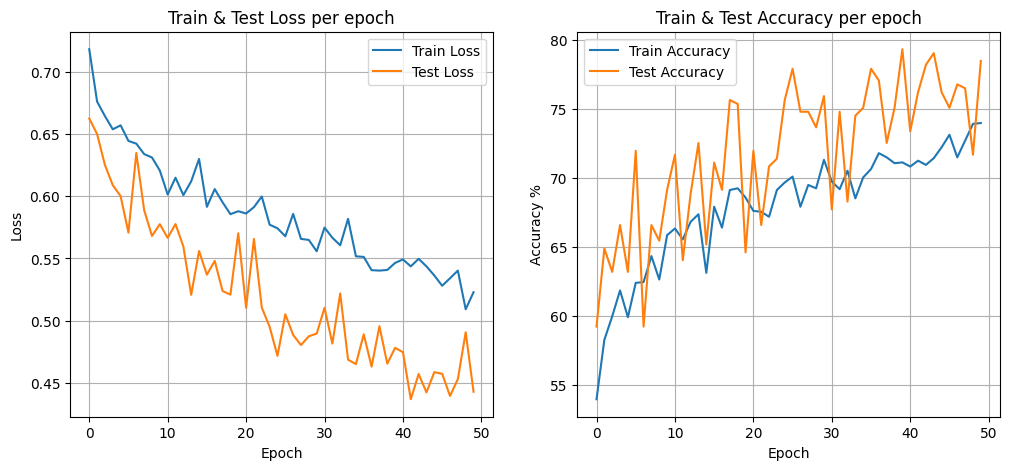

In [374]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()

In [375]:
from torch.utils.data import Subset

In [376]:
train_100_images = Subset(train_data_augmentation, range(100))
test_20_images = Subset(test_data_augmentation, range(20))

len(train_100_images), len(test_20_images)

(100, 20)